# scATAC-seq analysis

Here we will use scATAC-seq dataset "buenrostro2018" as an example to illustrate how SIMBA performs scATAC-seq analysis

In [1]:
import os
import simba as si
si.__version__

'1.0'

In [2]:
workdir = 'result_simba_atacseq'
si.settings.set_workdir(workdir)

Saving results in: result_simba_atacseq


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### load example data

In [6]:
adata_CP = si.datasets.atac_buenrostro2018()


atac_buenrostro2018.h5ad: 0.00B [00:00, ?B/s]

atac_buenrostro2018.h5ad: 145MB [01:45, 1.38MB/s]                               


Downloaded to result_simba_atacseq/data.


In [7]:
adata_CP

AnnData object with n_obs × n_vars = 2034 × 237450
    obs: 'celltype'
    var: 'chr', 'start', 'end'

### preprocessing

In [8]:
si.pp.filter_peaks(adata_CP,min_n_cells=3)

Before filtering: 
2034 cells, 237450 peaks
Filter peaks based on min_n_cells


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


After filtering out low-expressed peaks: 
2034 cells, 200167 peaks


In [9]:
si.pp.cal_qc_atac(adata_CP)

different ways to visualize the QC metrics

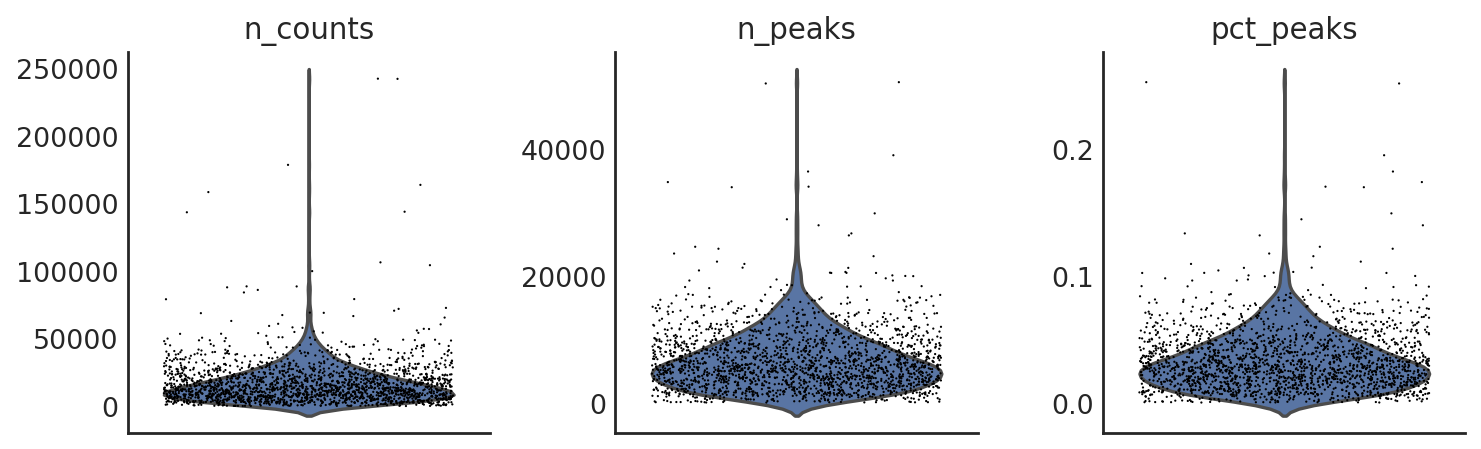

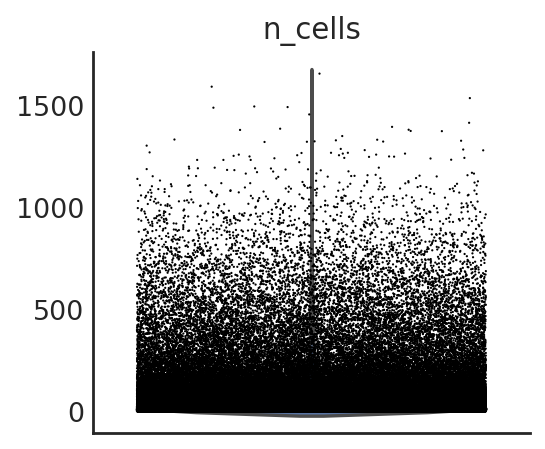

In [10]:
si.pl.violin(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], list_var=['n_cells'],fig_size=(3,3))

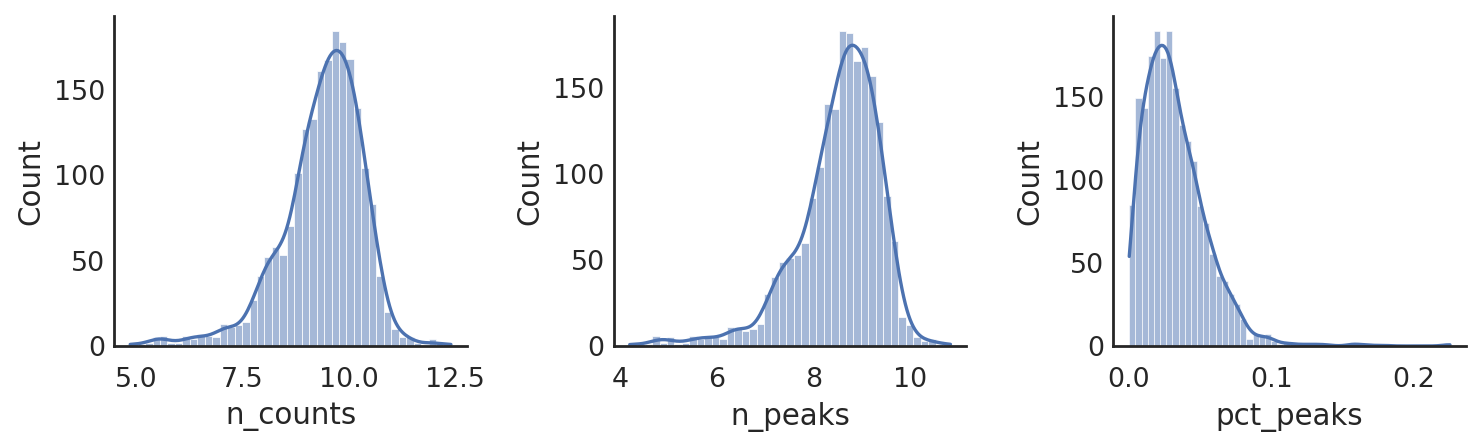

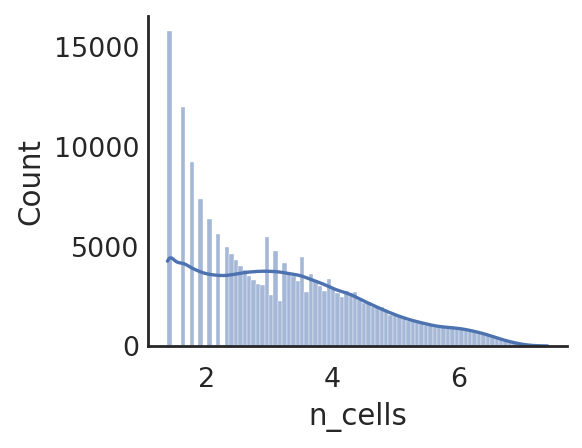

In [11]:
si.pl.hist(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], log=True, list_var=['n_cells'],fig_size=(3,3))

Filter out cells if needed:

```python
si.pp.filter_cells_atac(adata_CP,min_n_peaks=100)
```

### select peaks (optional)

It will speed up the trainning process by only keeping peaks associated with top PCs

In [12]:
si.pp.pca(adata_CP, n_components=50)

the number of selected PC is: 50


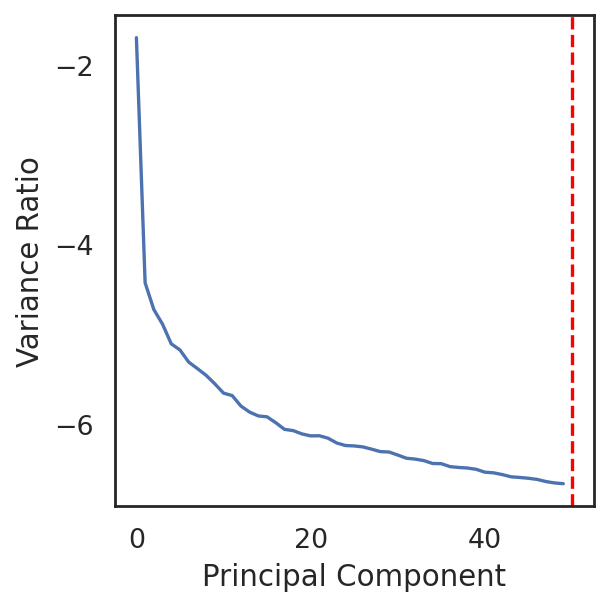

In [13]:
si.pl.pca_variance_ratio(adata_CP, show_cutoff=True)

The number of selected PCs can be further reduced:

```python
si.pp.select_pcs(adata_CP,n_pcs=30)
```

Select features associated with each of these PCs. The number of features for each PC will be automatically decided

In [14]:
si.pp.select_pcs_features(adata_CP)

#features selected from PC 0: 33368
#features selected from PC 1: 33415
#features selected from PC 2: 33361
#features selected from PC 3: 33397
#features selected from PC 4: 33375
#features selected from PC 5: 33431
#features selected from PC 6: 33395
#features selected from PC 7: 33442
#features selected from PC 8: 33372
#features selected from PC 9: 33376
#features selected from PC 10: 33364
#features selected from PC 11: 33393
#features selected from PC 12: 33372
#features selected from PC 13: 33434
#features selected from PC 14: 33369
#features selected from PC 15: 33395
#features selected from PC 16: 33422
#features selected from PC 17: 33379
#features selected from PC 18: 33366
#features selected from PC 19: 33498
#features selected from PC 20: 33365
#features selected from PC 21: 33569
#features selected from PC 22: 33364
#features selected from PC 23: 33376
#features selected from PC 24: 33427
#features selected from PC 25: 33367
#features selected from PC 26: 33381
#features s

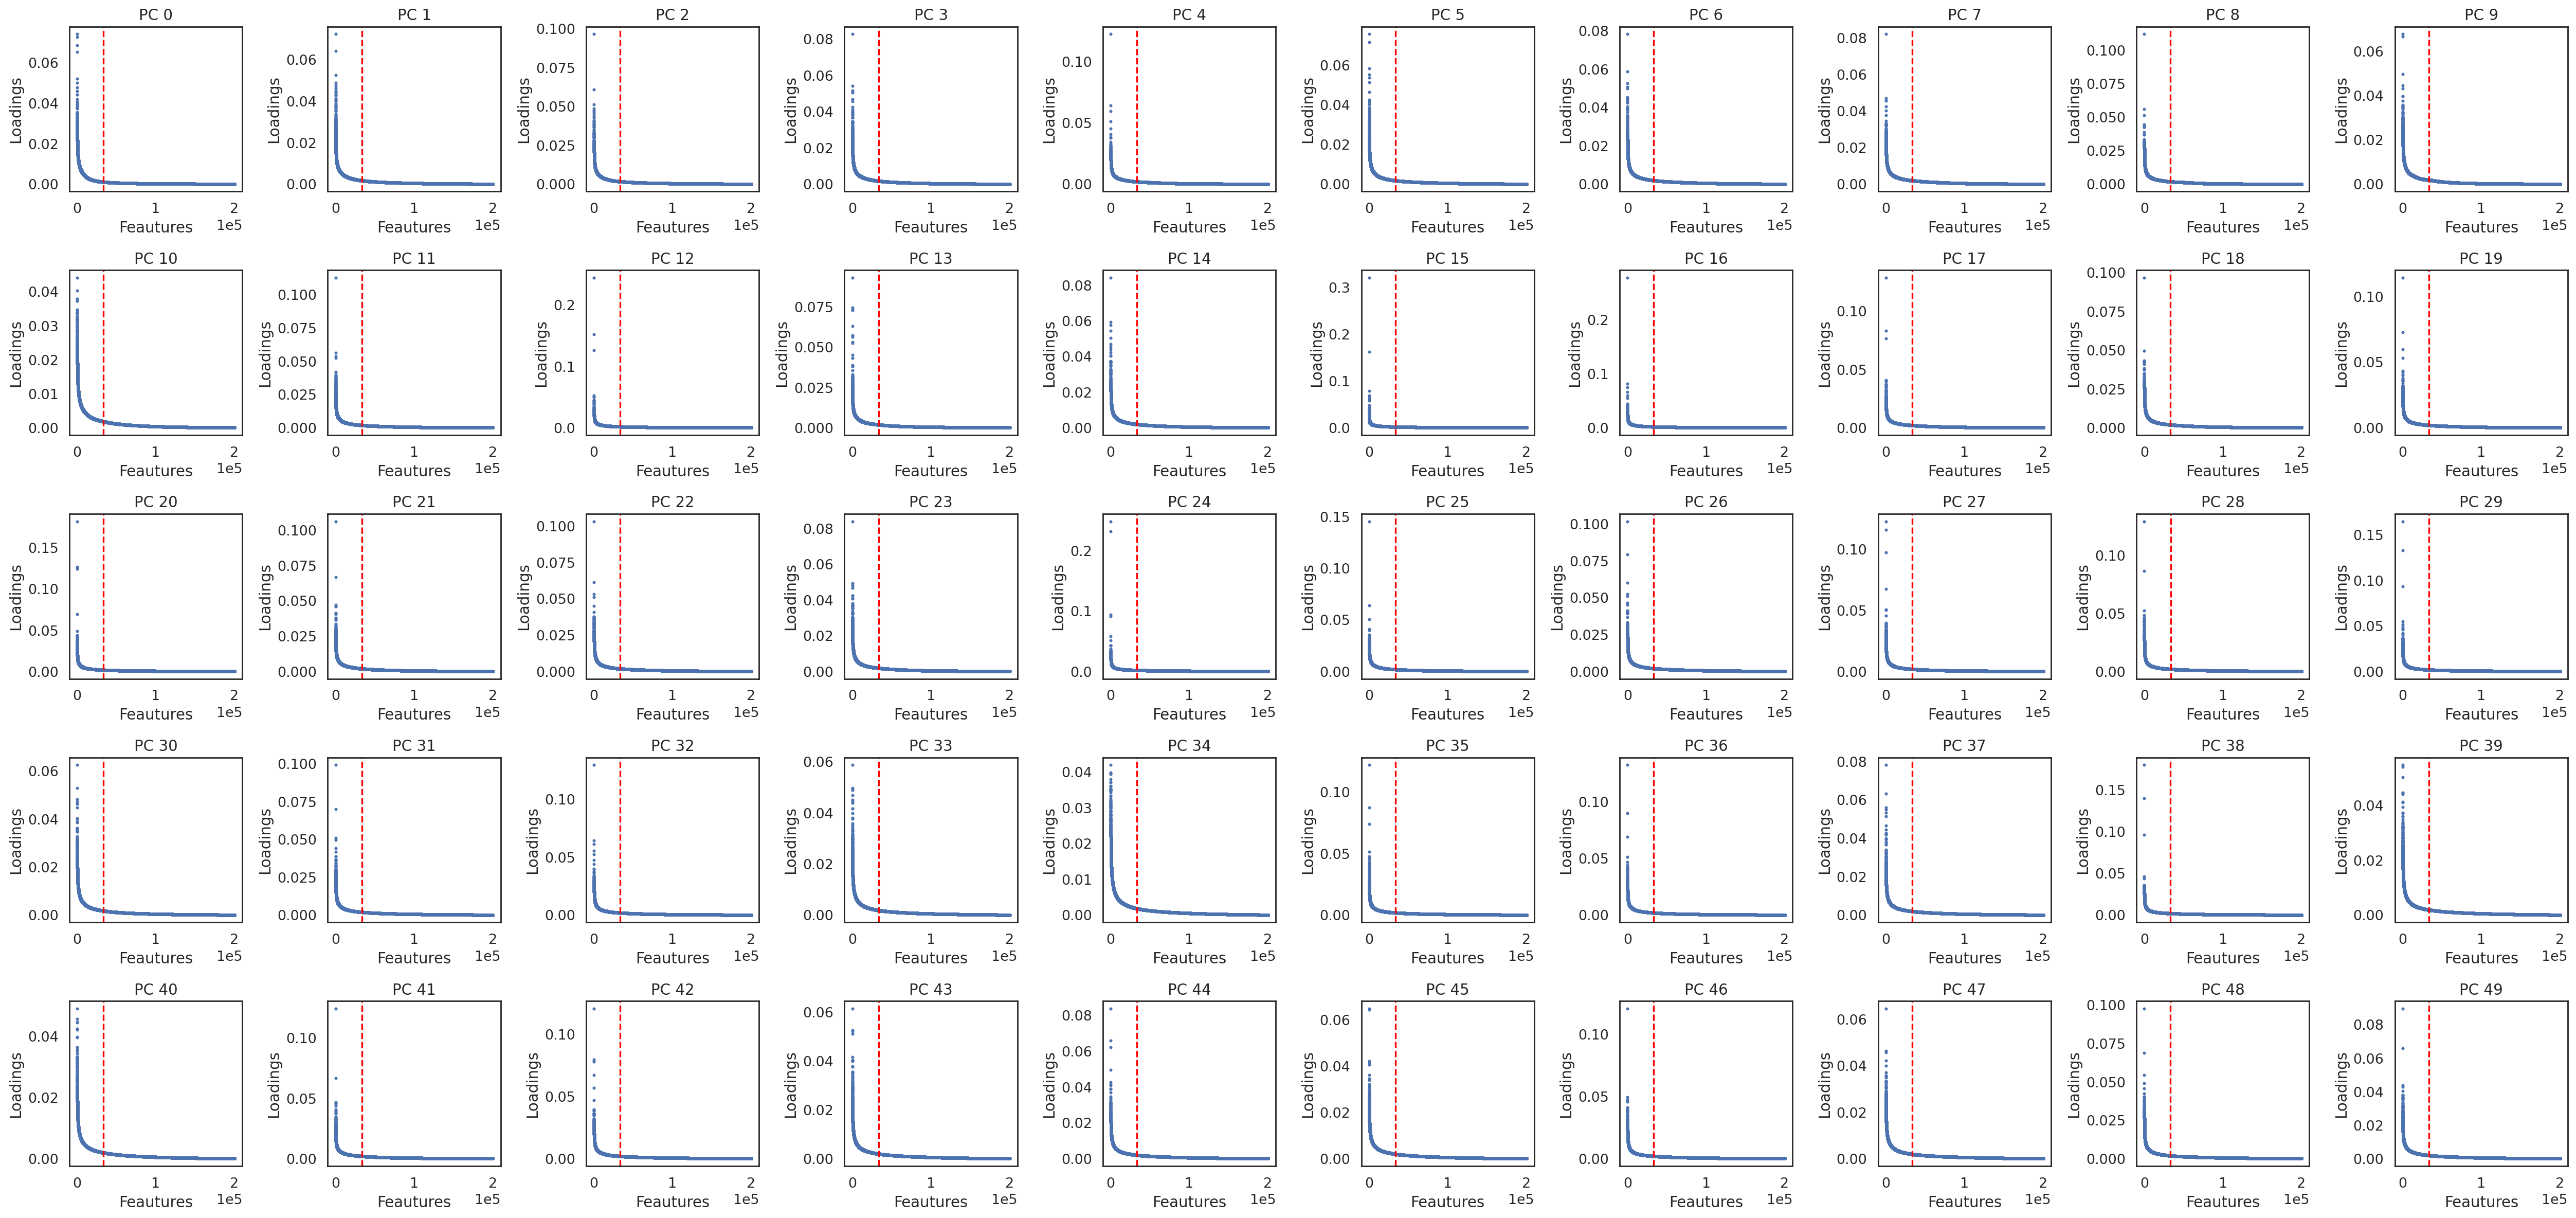

In [15]:
si.pl.pcs_features(adata_CP, fig_ncol=10)

### select DNA sequences (Optional) 

DNA sequences such as TF motifs or k-mers can be also encoded into the graph if needed.<br>

To scan peaks for kmers and motifs, first write the peak bed files.

In [16]:
si.write_bed(adata_CP, use_top_pcs=True)

"peaks.bed" was written to "result_multiome_shareseq".


Then run the provided R script “[scan_for_kmers_motifs.R](https://raw.githubusercontent.com/pinellolab/simba/master/R_scripts/scan_for_kmers_motifs.R)” under the result directory (‘hg19.fa’ can be downloaded [here](https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz))

In [17]:
os.chdir(workdir)

In [18]:
#! wget https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz
#! gunzip hg19.fa.gz
! wget https://raw.githubusercontent.com/pinellolab/simba/master/R_scripts/scan_for_kmers_motifs.R

--2021-11-09 17:40:40--  https://raw.githubusercontent.com/pinellolab/simba/master/R_scripts/scan_for_kmers_motifs.R
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5767 (5.6K) [text/plain]
Saving to: ‘scan_for_kmers_motifs.R’

scan_for_kmers_moti 100%[===================>]   5.63K  --.-KB/s    in 0s      

2021-11-09 17:40:40 (11.3 MB/s) - ‘scan_for_kmers_motifs.R’ saved [5767/5767]



> [Install the required packages](https://github.com/pinellolab/simba/blob/master/R_scripts/README.md) in your enviroment with the following command:
```bash
$ conda install r-essentials r-optparse bioconductor-jaspar2020 bioconductor-biostrings bioconductor-tfbstools bioconductor-motifmatchr bioconductor-summarizedexperiment r-doparallel bioconductor-rhdf5 bioconductor-hdf5array
```

In [19]:
%time
! Rscript scan_for_kmers_motifs.R -i peaks.bed -g hg19.fa -s 'Homo sapiens'

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 14.8 µs
[1] "Converting .bed to .fasta ..."
[1] "Scanning for kmers ..."
[1] "Scanning for TF motifs ..."
[1] "Saving kmer matrix ..."
[1] "Saving motif matrix ..."
[1] "Finished."


In [20]:
os.chdir("../")

In [21]:
adata_PK = si.read_hdf(os.path.join(workdir,'output_kmers_motifs/freq_kmer.h5'),'mat')
adata_PM = si.read_hdf(os.path.join(workdir,'output_kmers_motifs/freq_motif.h5'),'mat')

# convert byte string to string
adata_PK.obs.index = [x.decode('utf-8') for x in adata_PK.obs.index]
adata_PK.var.index = [x.decode('utf-8') for x in adata_PK.var.index]

adata_PM.obs.index = [x.decode('utf-8') for x in adata_PM.obs.index]
adata_PM.var.index = [x.decode('utf-8') for x in adata_PM.var.index]

In [22]:
adata_PK

AnnData object with n_obs × n_vars = 134535 × 4096

In [23]:
adata_PM

AnnData object with n_obs × n_vars = 134535 × 633

In [24]:
si.pp.binarize(adata_PK)
si.pp.binarize(adata_PM)

select kmers and motifs (optional)

In [25]:
si.pp.pca(adata_PK, n_components=50)
si.pp.pca(adata_PM, n_components=50)

In [26]:
si.pp.select_pcs_features(adata_PK, min_elbow=adata_PK.shape[1]/5, S=5)
si.pp.select_pcs_features(adata_PM, min_elbow=adata_PM.shape[1]/5, S=5)

#features selected from PC 0: 819
#features selected from PC 1: 828
#features selected from PC 2: 1491
#features selected from PC 3: 1495
#features selected from PC 4: 1981
#features selected from PC 5: 1710
#features selected from PC 6: 1277
#features selected from PC 7: 1877
#features selected from PC 8: 819
#features selected from PC 9: 1622
#features selected from PC 10: 1464
#features selected from PC 11: 1523
#features selected from PC 12: 1557
#features selected from PC 13: 1671
#features selected from PC 14: 1767
#features selected from PC 15: 1755
#features selected from PC 16: 2032
#features selected from PC 17: 1975
#features selected from PC 18: 819
#features selected from PC 19: 1843
#features selected from PC 20: 2072
#features selected from PC 21: 1766
#features selected from PC 22: 1711
#features selected from PC 23: 1861
#features selected from PC 24: 2002
#features selected from PC 25: 1891
#features selected from PC 26: 1820
#features selected from PC 27: 1886
#featu

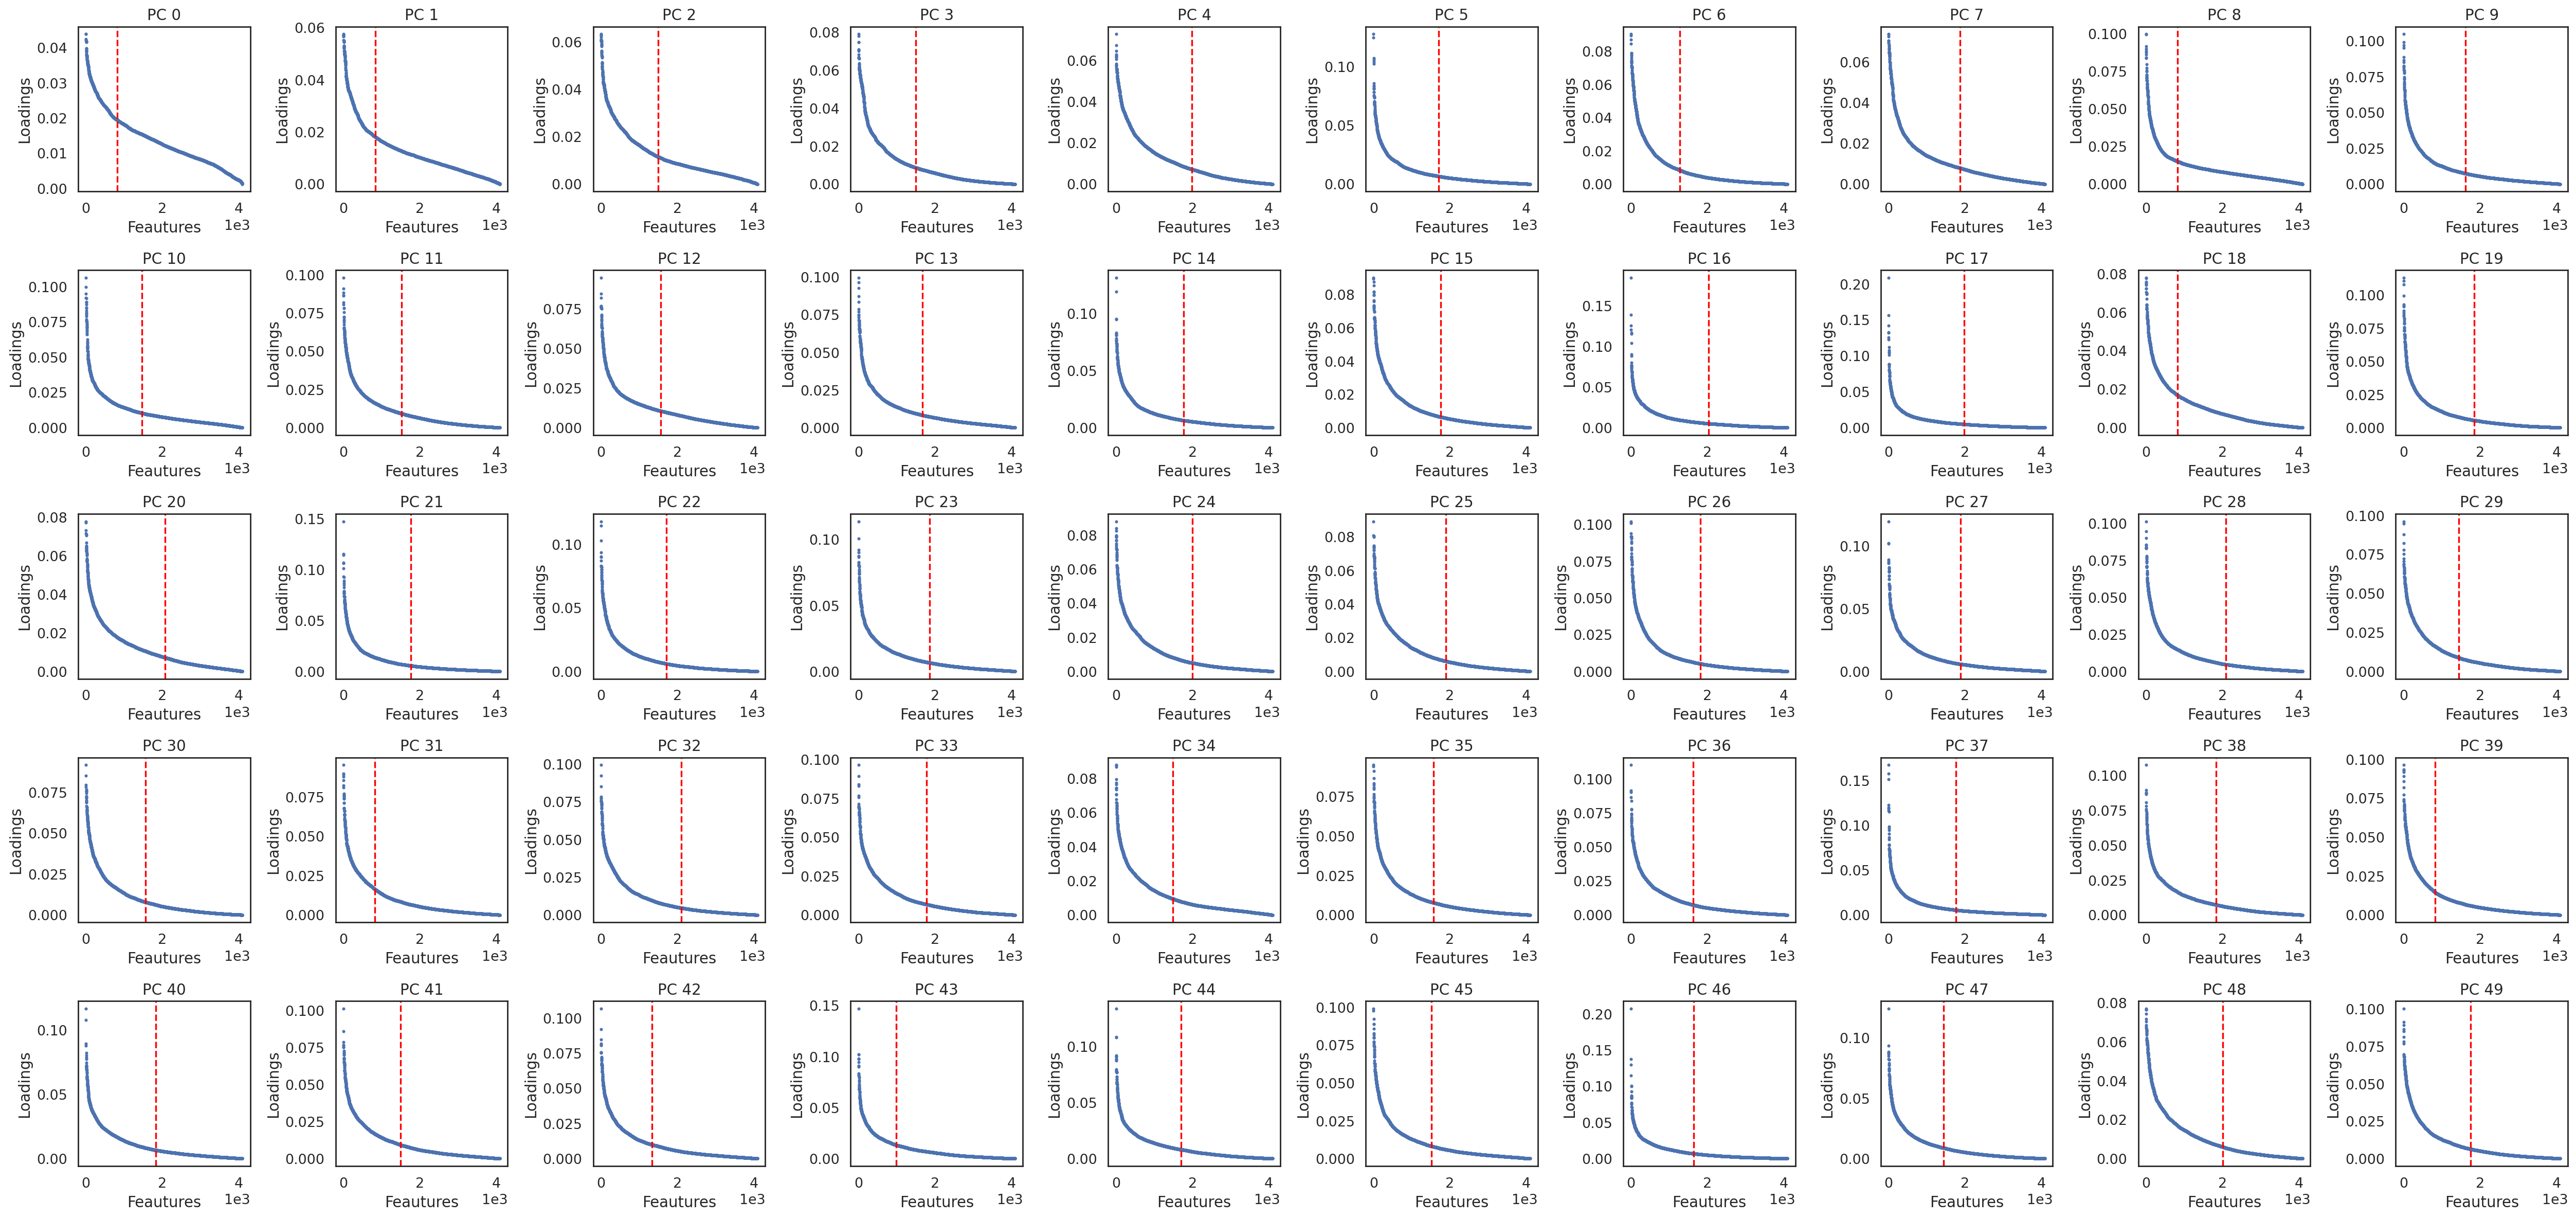

In [27]:
si.pl.pcs_features(adata_PK, fig_ncol=10)

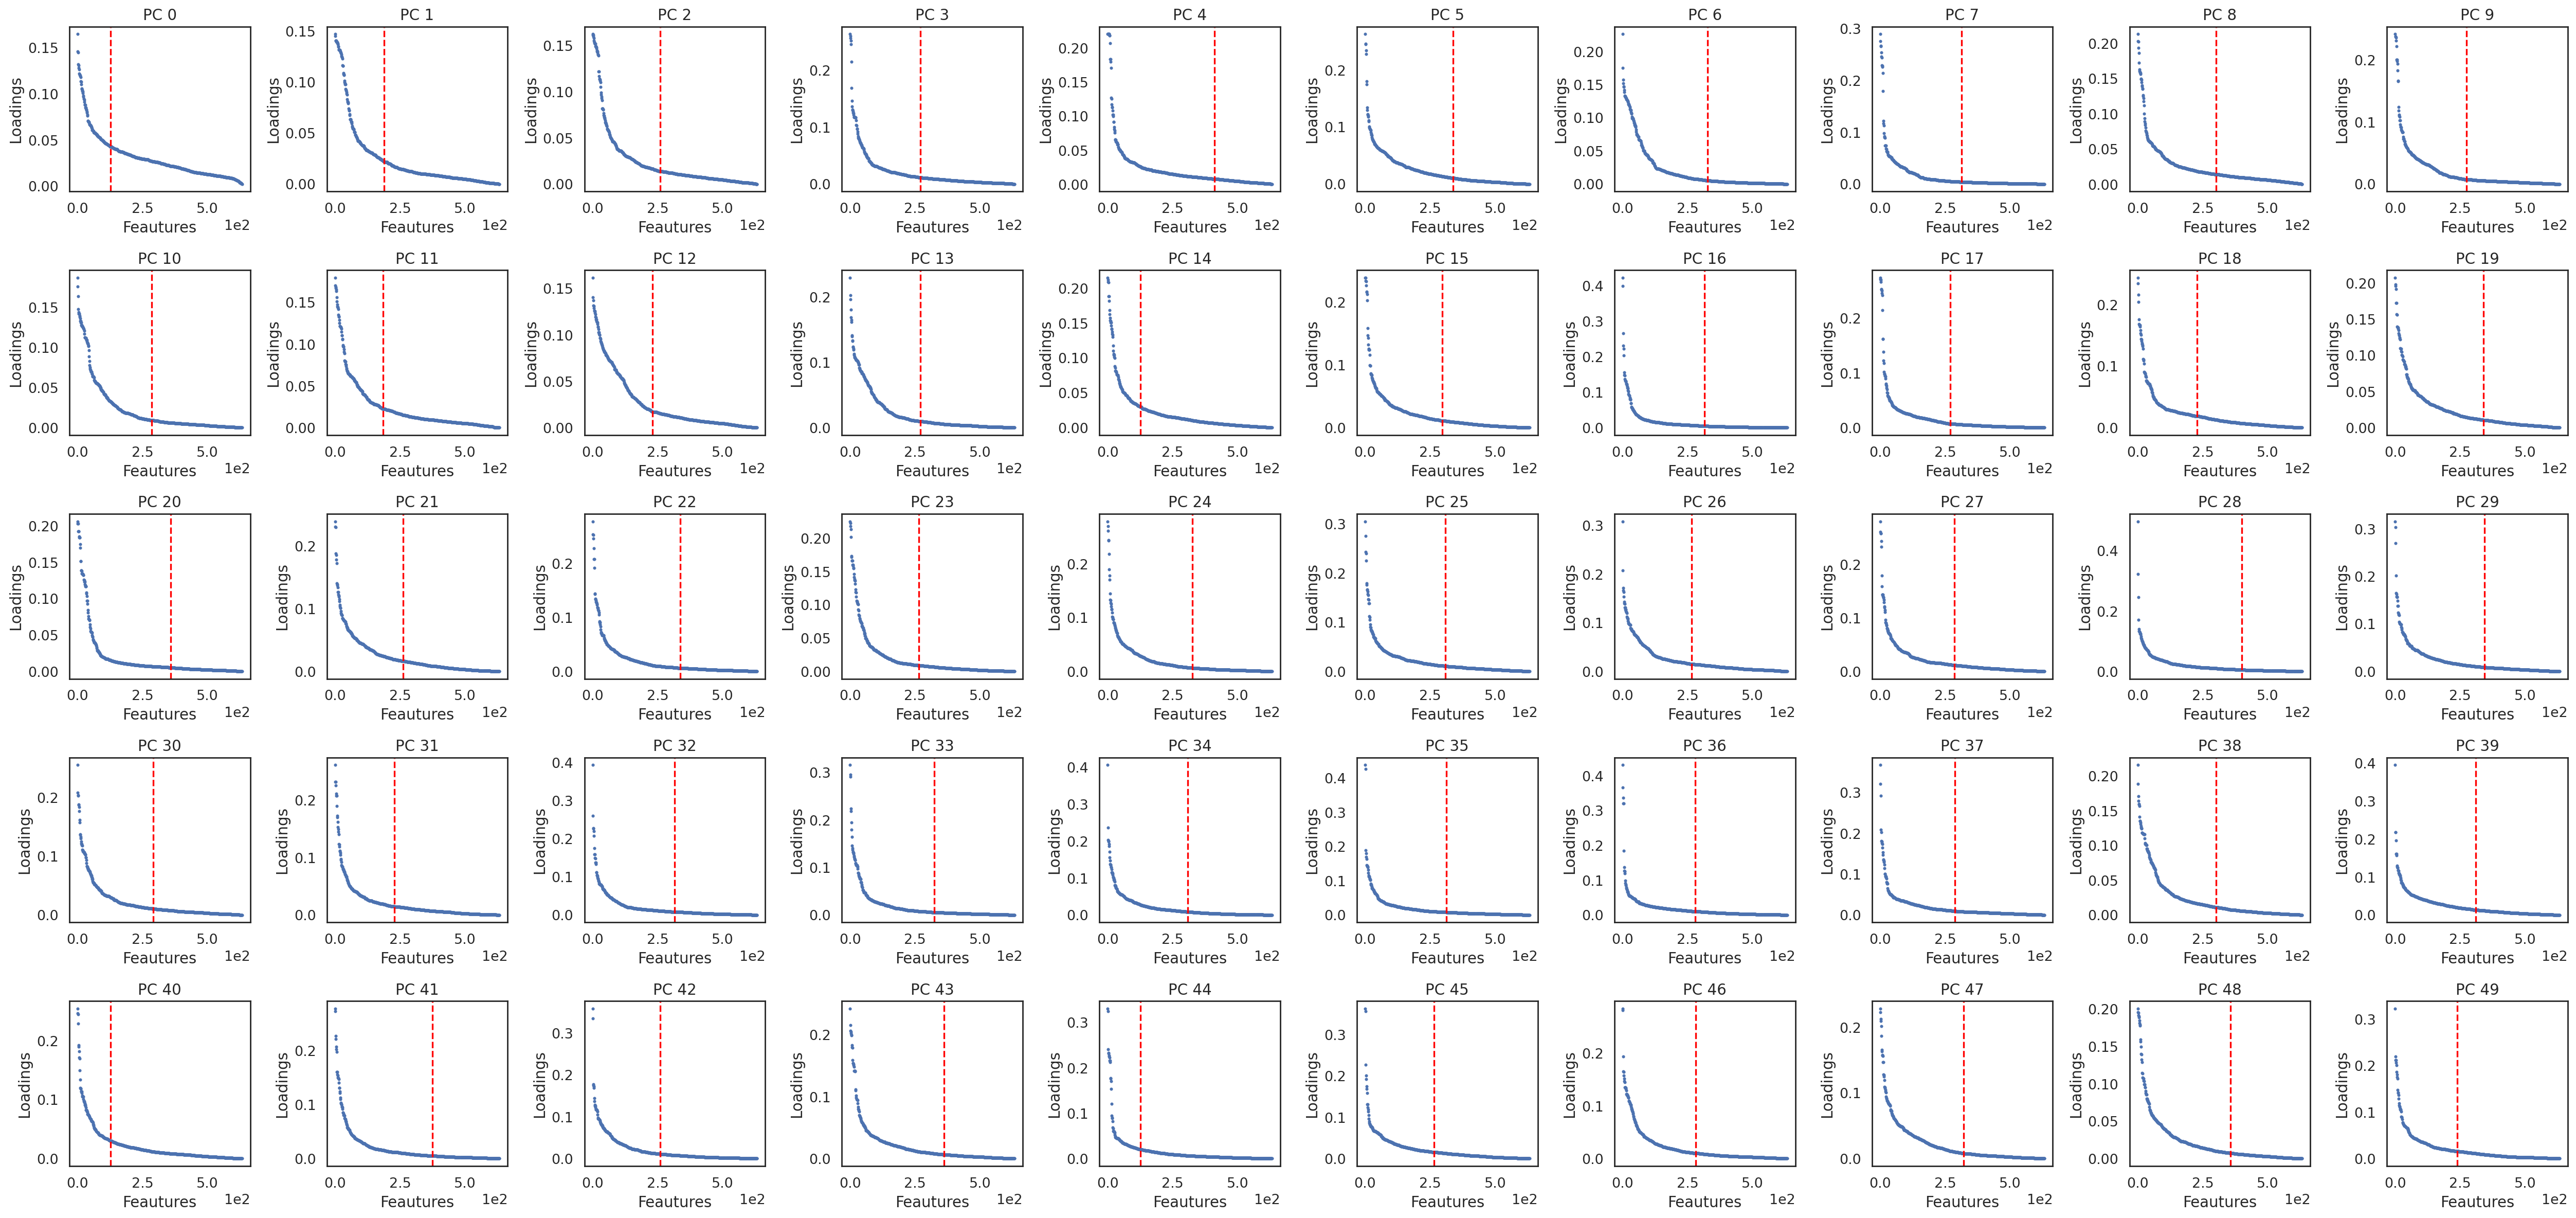

In [28]:
si.pl.pcs_features(adata_PM, fig_ncol=10)

### generate graph

In [29]:
si.tl.gen_graph(list_CP=[adata_CP],
                list_PK=[adata_PK],
                list_PM=[adata_PM],
                copy=False,
                use_top_pcs=True,
                dirname='graph0')

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


relation0: source: C, destination: P
#edges: 12977763
relation1: source: P, destination: M
#edges: 5749259
relation2: source: P, destination: K
#edges: 57893992
Total number of edges: 76621014
Writing graph file "pbg_graph.txt" to "result_simba_atacseq/pbg/graph0" ...
Finished.


### PBG training

Before PBG training, let’s take a look at the parameters:

In [30]:
si.settings.pbg_params

{'entity_path': 'result_simba_atacseq/pbg/graph0/input/entity',
 'edge_paths': ['result_simba_atacseq/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1},
  'P': {'num_partitions': 1},
  'K': {'num_partitions': 1},
  'M': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'P',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'P', 'rhs': 'M', 'operator': 'none', 'weight': 0.2},
  {'name': 'r2', 'lhs': 'P', 'rhs': 'K', 'operator': 'none', 'weight': 0.02}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.0,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_negs': 50,
 'checkpoint_preservation_interval': None}

If no parameters need to be adjusted, the training can be simply done with:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we show how to adjust training-related parameters if needed. In general, weight decay `wd` is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided `wd` (enabling it by setting `auto_wd=True`) works well.

E.g. we want to change the number of cpus `workers`:

In [31]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.000309 
dict_config['workers'] = 12

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 0.000309
`.settings.pbg_params['wd']` has been updated to 0.000309
Converting input data ...
[2021-06-24 14:59:10.962921] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2021-06-24 14:59:10.963252] These files are in: result_simba_atacseq/pbg/graph0/input/entity, result_simba_atacseq/pbg/graph0/input/edge
Starting training ...
Finished


> If `wd` is specified by users instead of being automatically decided, then make sure to update it in simba setting:
```python
si.settings.pbg_params = dict_config.copy()
```

The trained result can be loaded in with the following steps:

By default, it's using the current training result stored in `.setting.pbg_params`
```python
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()
```
Users can also specify different pathss
```python
# load in graph ('graph0') info
si.load_graph_stats(path='./result_simba_atacseq/pbg/graph0/')
# load in model info for ('graph0')
si.load_pbg_config(path='./result_simba_atacseq/pbg/graph0/model/')
```

plotting training metrics to make sure the model is not overfitting

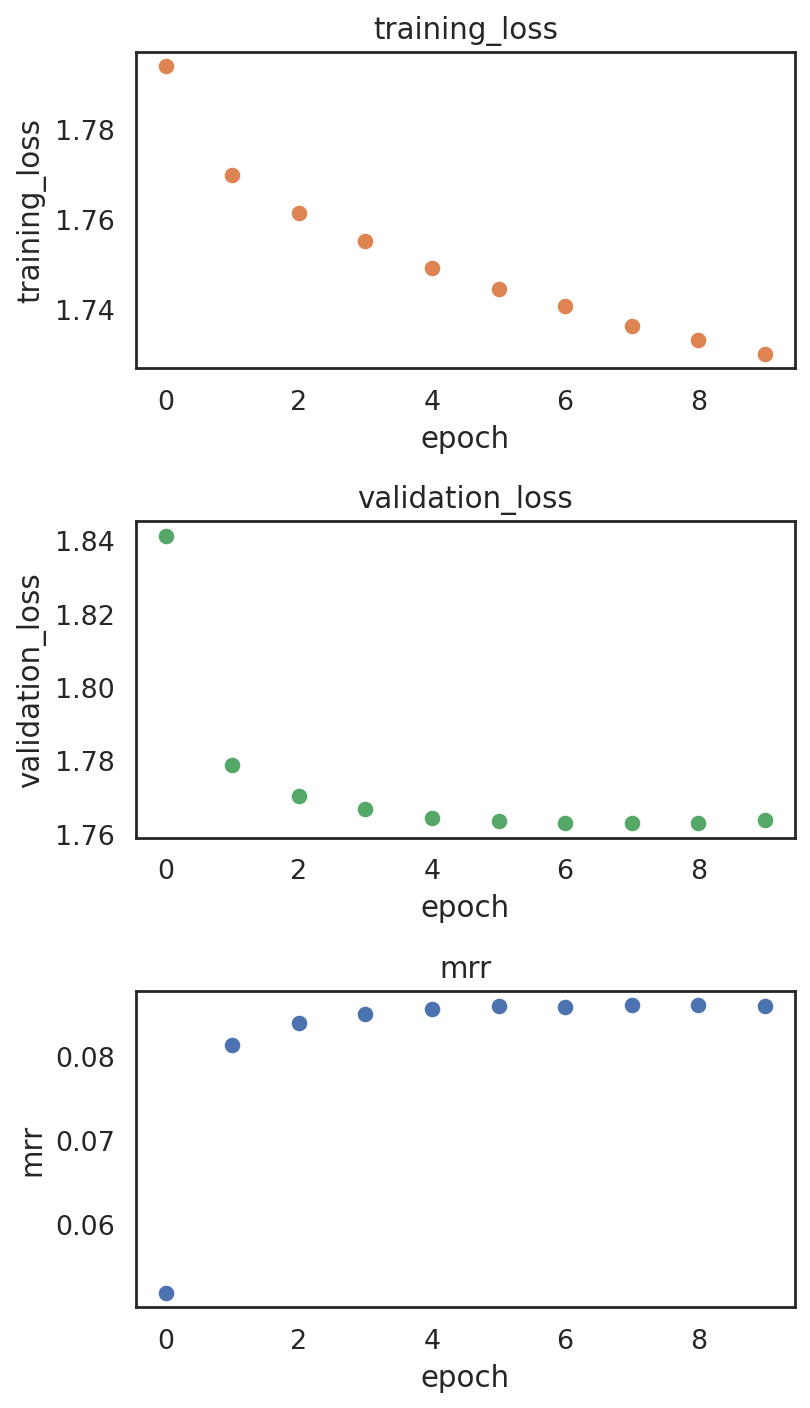

In [32]:
si.pl.pbg_metrics(fig_ncol=1)

### post-training analysis

In [33]:
palette_celltype={'HSC':"#00441B", 'MPP':"#46A040", 'LMPP':"#00AF99", 'CMP':"#FFC179",'CLP':"#98D9E9",
                  'MEP':"#F6313E", 'GMP':"#FFA300", 'pDC':"#C390D4", 'mono':"#FF5A00",'UNK':"#333333"}

In [34]:
dict_adata = si.read_embedding()

In [35]:
dict_adata

{'C': AnnData object with n_obs × n_vars = 2034 × 50,
 'K': AnnData object with n_obs × n_vars = 3601 × 50,
 'P': AnnData object with n_obs × n_vars = 134535 × 50,
 'M': AnnData object with n_obs × n_vars = 601 × 50}

In [37]:
adata_C = dict_adata['C']  # embeddings for cells
adata_P = dict_adata['P']  # embeddings for peaks
adata_M = dict_adata['M']  # embeddings for motifs
adata_K = dict_adata['K']  # embeddings for kmers

In [38]:
adata_C

AnnData object with n_obs × n_vars = 2034 × 50

In [39]:
adata_P

AnnData object with n_obs × n_vars = 134535 × 50

In [40]:
adata_M

AnnData object with n_obs × n_vars = 601 × 50

In [41]:
adata_K

AnnData object with n_obs × n_vars = 3601 × 50

visualize embeddings of cells

In [42]:
## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CP[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2034 × 50
    obs: 'celltype'

In [43]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

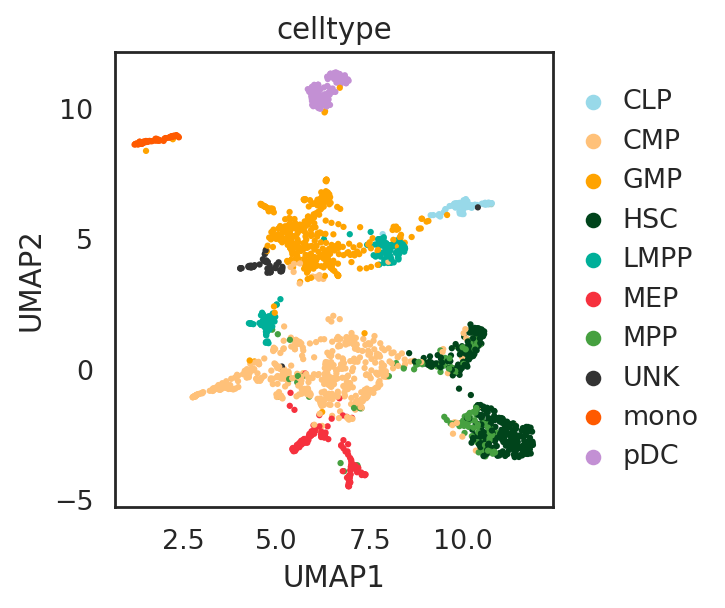

In [44]:
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(4.5,4),
           drawing_order='random')

visualize embeddings of cells, motifs, kmers, and peaks

In [45]:
adata_all = si.tl.embed(adata_ref=adata_C,
                        list_adata_query=[adata_M, adata_K, adata_P])

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;
Performing softmax transformation for query data 2;


In [46]:
## add annotations of all entities
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all.obs.loc[adata_P.obs_names, 'entity_anno'] = 'peak'
adata_all.obs.loc[adata_K.obs_names, 'entity_anno'] = 'kmer'
adata_all.obs.loc[adata_M.obs_names, 'entity_anno'] = 'motif'

adata_all.obs.head()

celltype id_dataset entity_anno
singles-BM0828-GMP-151027-21             GMP        ref         GMP
singles-BM0828-MPP-frozen-151103-68      MPP        ref         MPP
singles-160822-BM1137-CMP-LS-92          CMP        ref         CMP
singles-PB1022-mono-160128-29           mono        ref        mono
singles-160819-BM1137-CMP-LS-8           CMP        ref         CMP

In [47]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)

In [48]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['peak'] = "#e5c2c8"
palette_entity_anno['kmer'] = "#94b1b7"
palette_entity_anno['motif'] = "#92ba79"

Trying to set attribute `.uns` of view, copying.


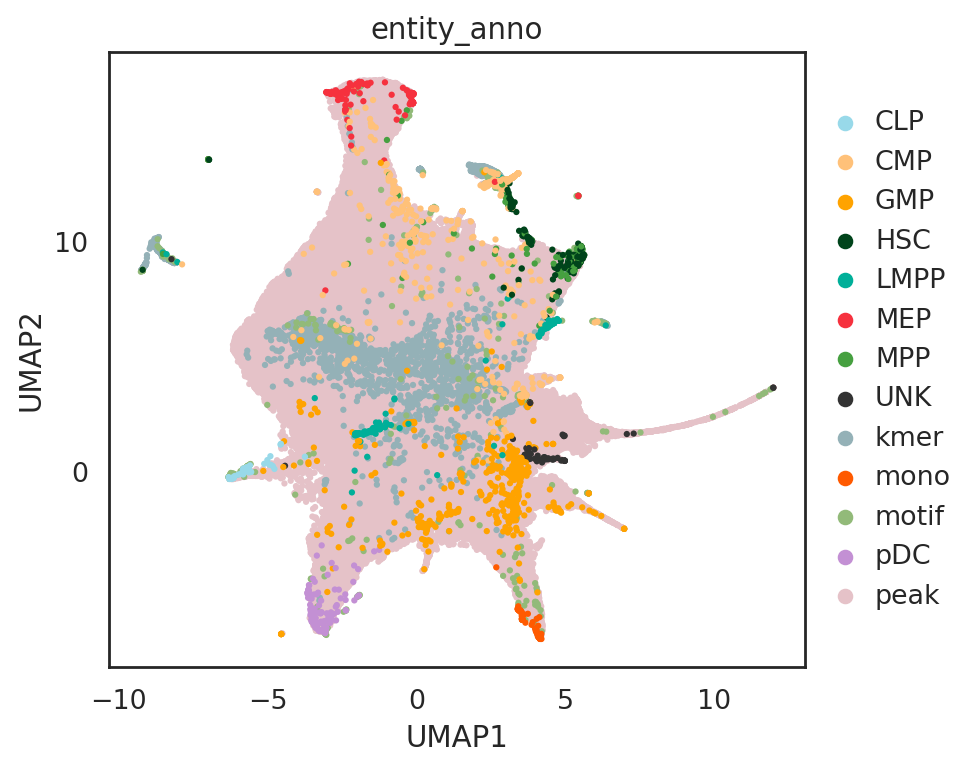

In [49]:
si.pl.umap(adata_all[::-1,], #reverse the order of entities
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(6,5),
           drawing_order='original',
           show_texts=False)

In [50]:
marker_tfs = ['PAX5', 'EBF1', # CLP
              'TCF12(var.2)', 'IRF8', 'TCF4',#pDC
              'CEBPB','CEBPD', #mono
              'MEIS1(var.2)', 'HOXA9', 'HOXA4',#HSC
              'GATA1', 'GATA3', #MEP
              'ATF4','STAT1',#CMP
              'ETV6', #GMP
             ]

marker_kmers = ['GATAAG', # GATA1
                'CAGCTG', # TCF4/TCF12
                'ATAAAT', # HOXA9
                'AGGAAA', # STAT1
                'CACTTC', #ETV6
               ]

marker_peaks = ['chr19_12997999_12998154', #KLF1
                'chr19_12998329_12998592', #KLF1
               ]

Trying to set attribute `.uns` of view, copying.


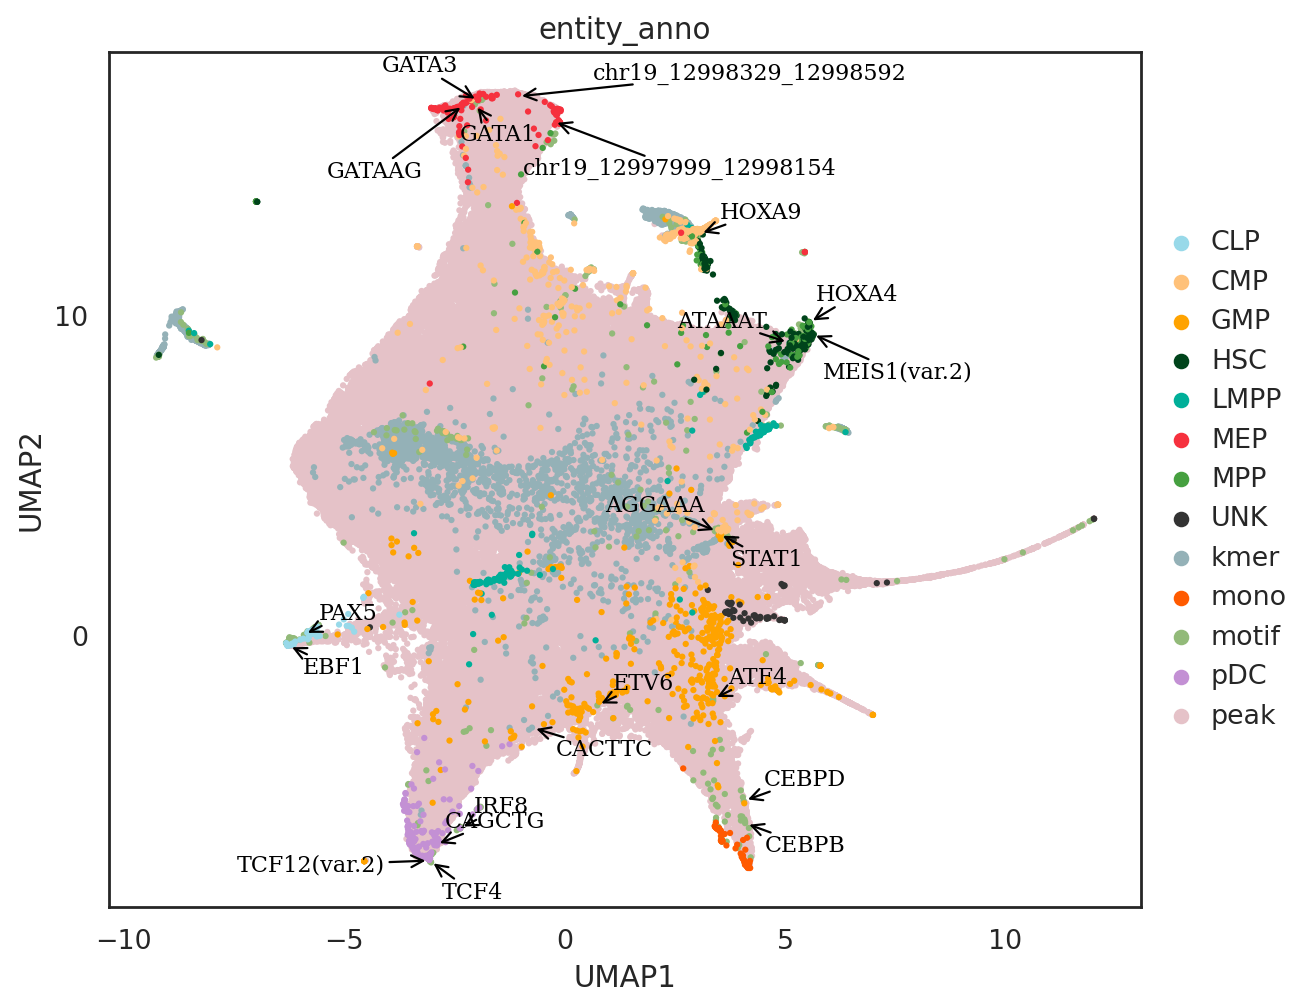

In [51]:
si.pl.umap(adata_all[::-1,],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           texts=marker_tfs + marker_kmers + marker_peaks,
           text_expand=(1.5,2),
           show_texts=True,
           fig_size=(8,6.5))

SIMBA metrics

In [52]:
# motifs
adata_cmp_CM = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_M)

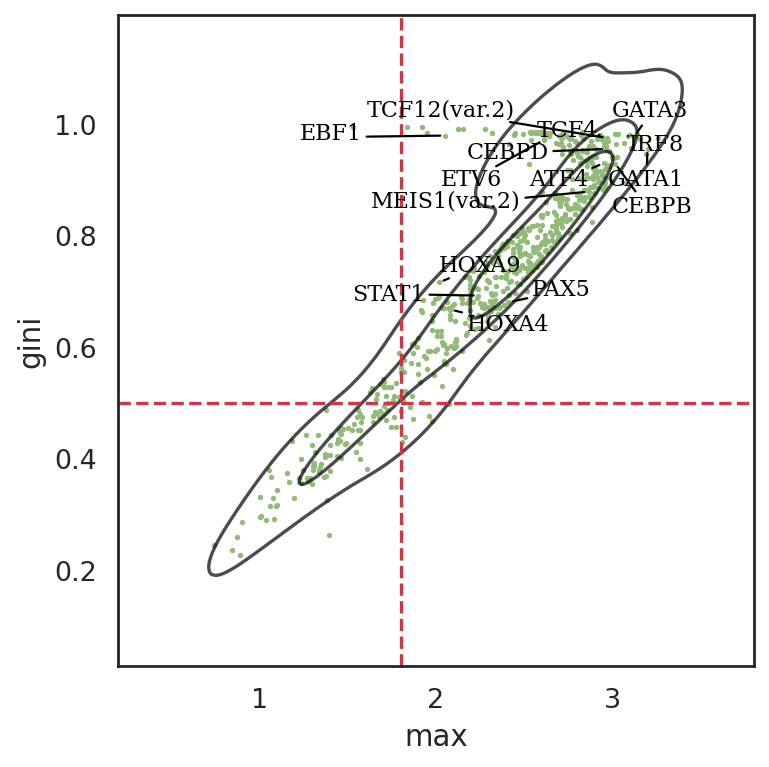

In [53]:
si.pl.entity_metrics(adata_cmp_CM,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=True,
                     texts=marker_tfs,
                     text_expand=(1.5,1.5),
                     size=2,
                     cutoff_x=1.8,
                     cutoff_y=0.5,
                     c='#92ba79',
                     save_fig=False)

In [54]:
# kmers
adata_cmp_CK = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_K)

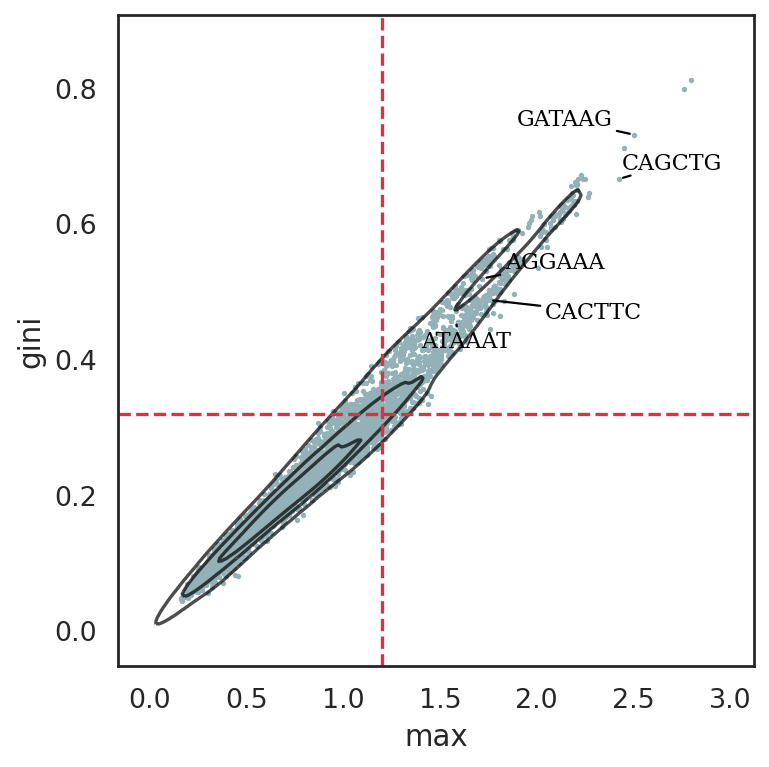

In [55]:
si.pl.entity_metrics(adata_cmp_CK,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=True,
                     texts=marker_kmers,
                     text_expand=(1.5,1.5),
                     size=2,
                     cutoff_x=1.2,
                     cutoff_y=0.32,
                     c='#94b1b7',
                     save_fig=False)

SIMBA barcode plots

In [56]:
adata_cmp_CM.obs['celltype'] = adata_CP.obs.loc[adata_cmp_CM.obs_names,'celltype']
adata_cmp_CK.obs['celltype'] = adata_CP.obs.loc[adata_cmp_CK.obs_names,'celltype']

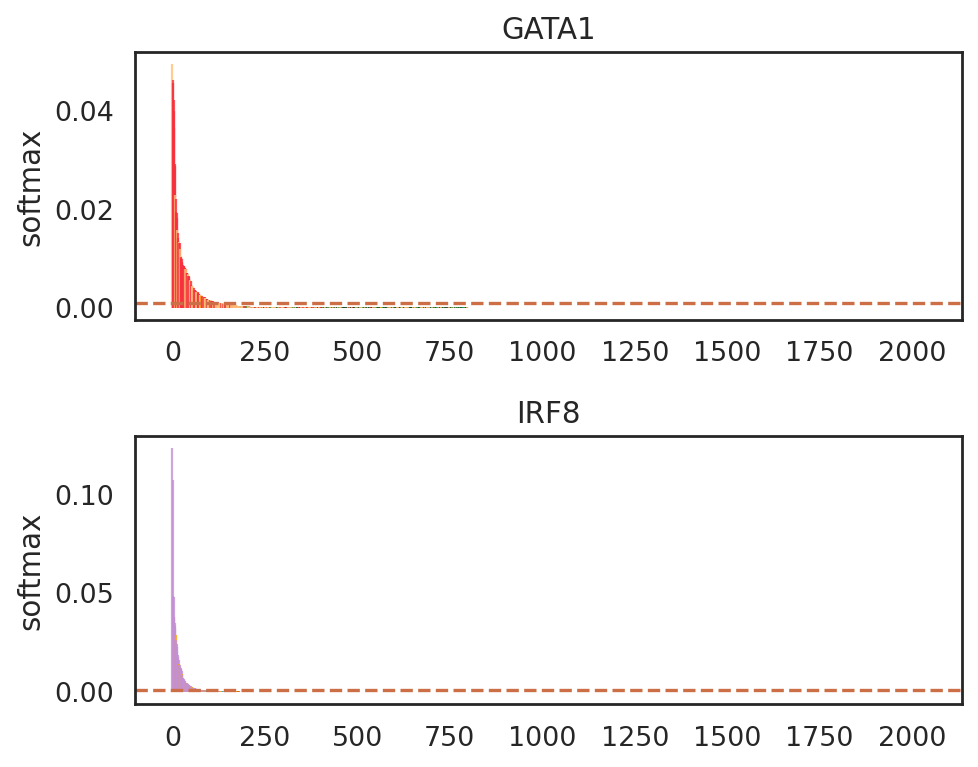

In [59]:
si.pl.entity_barcode(adata_cmp_CM, 
                     layer='softmax',
                     entities=['GATA1', 'IRF8'], 
                     anno_ref='celltype',
                     show_cutoff=True,
                     cutoff=0.001,
                     palette=palette_celltype,
                     fig_size=(6, 2.5),
                     save_fig=False)

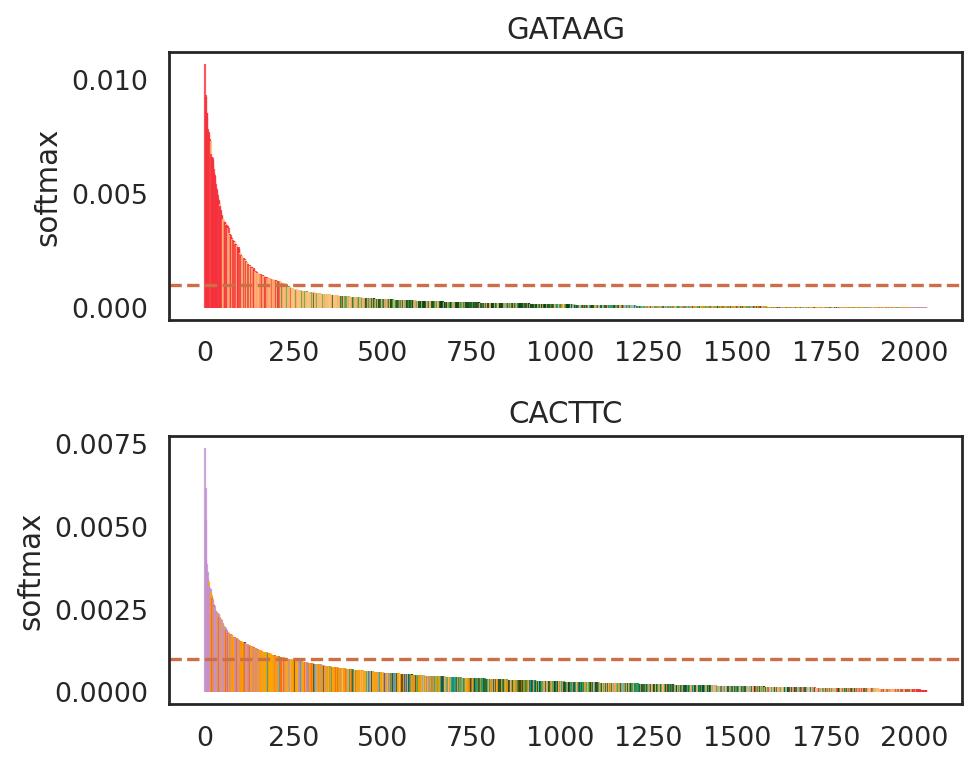

In [60]:
si.pl.entity_barcode(adata_cmp_CK, 
                     layer='softmax',
                     entities=['GATAAG', 'CACTTC'], 
                     anno_ref='celltype',
                     show_cutoff=True,
                     cutoff=0.001,
                     palette=palette_celltype,
                     fig_size=(6, 2.5),
                     save_fig=False)

SIMBA queries

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


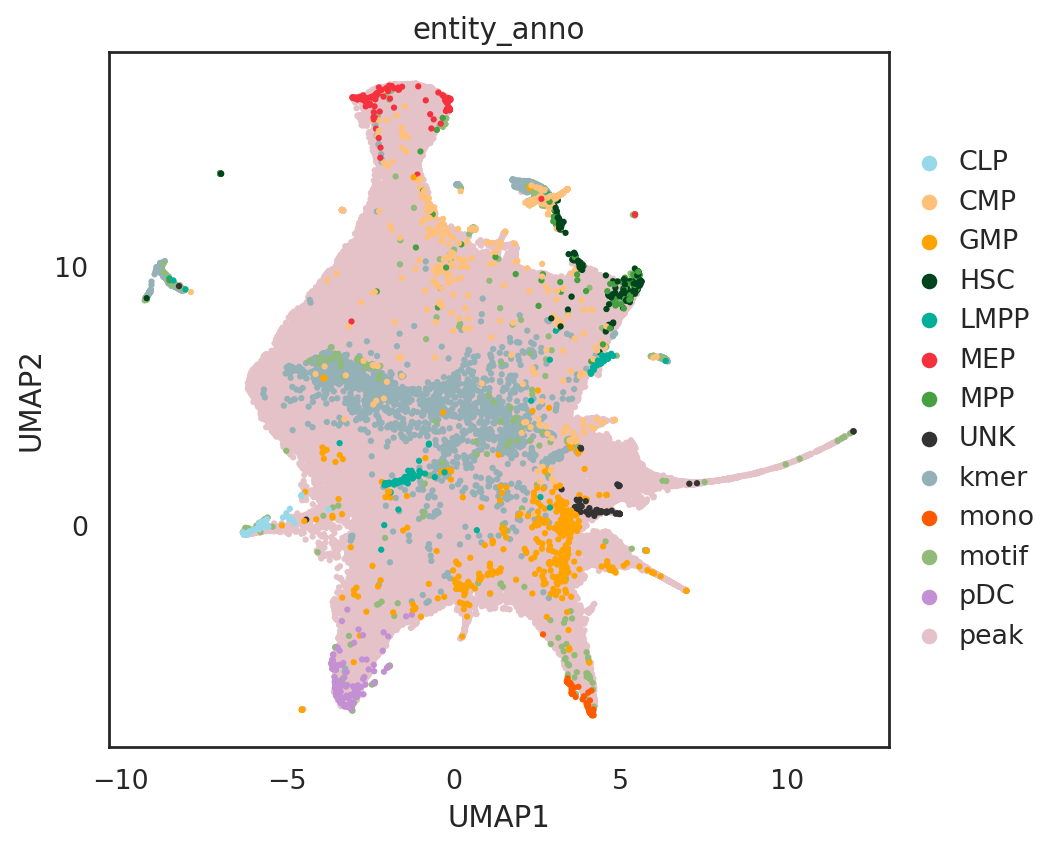

In [61]:
si.pl.umap(adata_all[::-1,],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6.5,5.5))

In [62]:
# find neighbor motif around the location [-1.5, 16] on UMAP
query_result = si.tl.query(adata_all,
                           pin=[-1.5,16],
                           obsm='X_umap',
                           use_radius=True,r=2,
                           anno_filter='entity_anno',
                           filters=['motif', 'kmer'])
print(query_result.shape)
query_result.iloc[:10,]

(31, 5)


celltype id_dataset entity_anno  distance  query
GATA6           nan    query_0       motif  0.603015      0
FOXF2           nan    query_0       motif  0.807087      0
GATA1           nan    query_0       motif  0.825012      0
GATA2           nan    query_0       motif  0.853963      0
GATA4           nan    query_0       motif  0.856798      0
GATA3           nan    query_0       motif  0.858775      0
GATA1_TAL1      nan    query_0       motif  0.886104      0
GATA5           nan    query_0       motif  0.892869      0
TTATCA          nan    query_1        kmer  0.901073      0
GAGATA          nan    query_1        kmer  0.904079      0

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


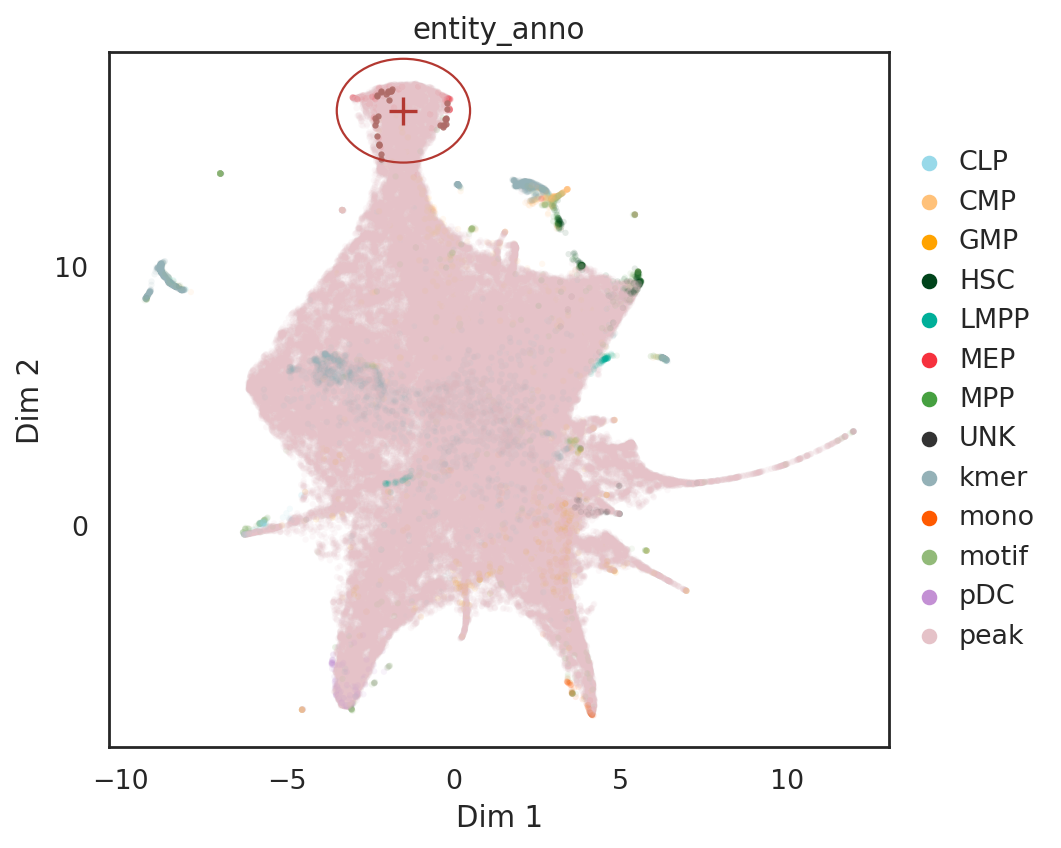

In [63]:
# show locations of pin point and its neighbor motifs and kmers 
si.pl.query(adata_all,
            show_texts=False, 
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(6.5,5.5))

In [64]:
# find top 500 neighbor peaks around TF motif 'CEBPB' in SIMBA embedding
query_result = si.tl.query(adata_all,
                           entity=['CEBPB'],
                           obsm=None,
                           use_radius=False,
                           k=500,
                           anno_filter='entity_anno',
                           filters=['peak'])
print(query_result.shape)
query_result.head()

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(500, 5)


celltype id_dataset entity_anno  distance  query
chr21_42738544_42739025        nan    query_2        peak  1.004674  CEBPB
chr10_104575728_104576298      nan    query_2        peak  1.016362  CEBPB
chr1_166481044_166481392       nan    query_2        peak  1.030337  CEBPB
chr15_101748029_101748534      nan    query_2        peak  1.046896  CEBPB
chr5_172313932_172314655       nan    query_2        peak  1.047440  CEBPB

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


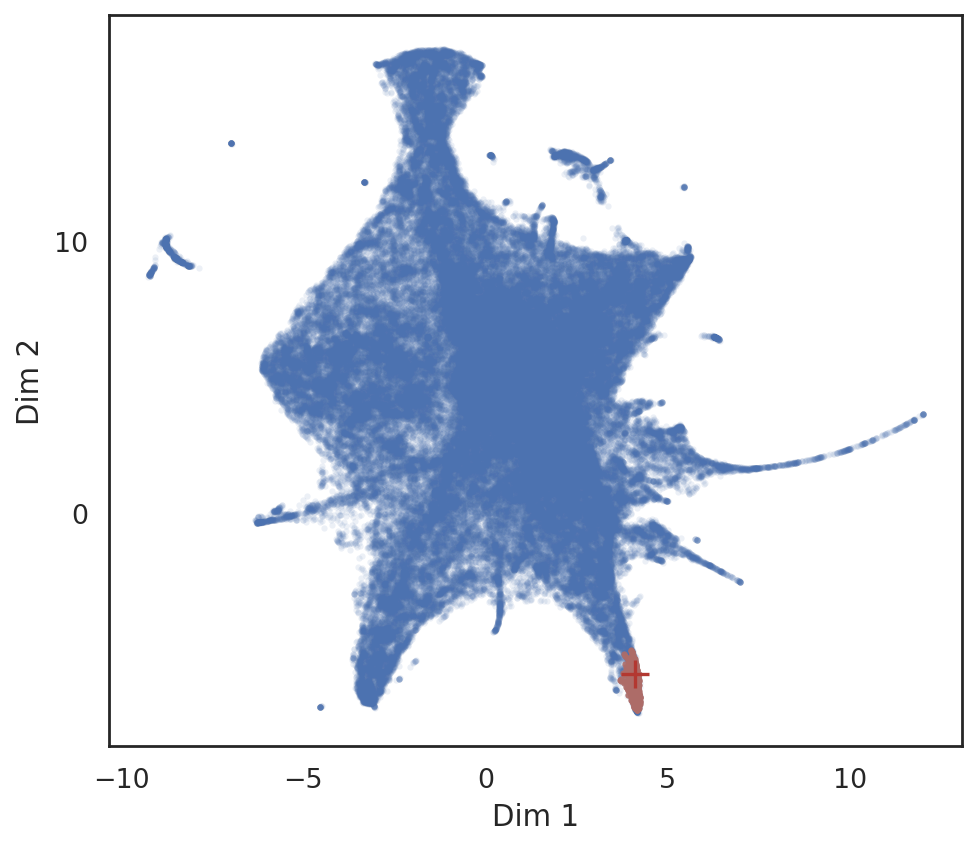

In [65]:
# show locations of neighbor peaks
si.pl.query(adata_all,
            show_texts=False, 
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(6.,5.5))

In [66]:
# find neighbor entities (both cells and features) of a given TF motif on UMAP
query_result = si.tl.query(adata_all,
                           entity=['PAX5'],
                           obsm='X_umap',
                           use_radius=False,
                           k=50)
print(query_result.shape)
query_result.iloc[:8,]

(50, 5)


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


celltype id_dataset entity_anno  distance  \
PAX5                                     nan    query_0       motif  0.000000   
HES2                                     nan    query_0       motif  0.068228   
singles-BM0828-CLP-frozen-151103-20      CLP        ref         CLP  0.100645   
BM1077-CLP-Frozen-160106-70              CLP        ref         CLP  0.117510   
BM1077-CLP-Frozen-160106-79              CLP        ref         CLP  0.118386   
GLIS3                                    nan    query_0       motif  0.121647   
HEY2                                     nan    query_0       motif  0.122658   
HES6                                     nan    query_0       motif  0.124835   

                                    query  
PAX5                                 PAX5  
HES2                                 PAX5  
singles-BM0828-CLP-frozen-151103-20  PAX5  
BM1077-CLP-Frozen-160106-70          PAX5  
BM1077-CLP-Frozen-160106-79          PAX5  
GLIS3                                PAX5  
HEY2                                 PAX5  
HES6                                 PAX5

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


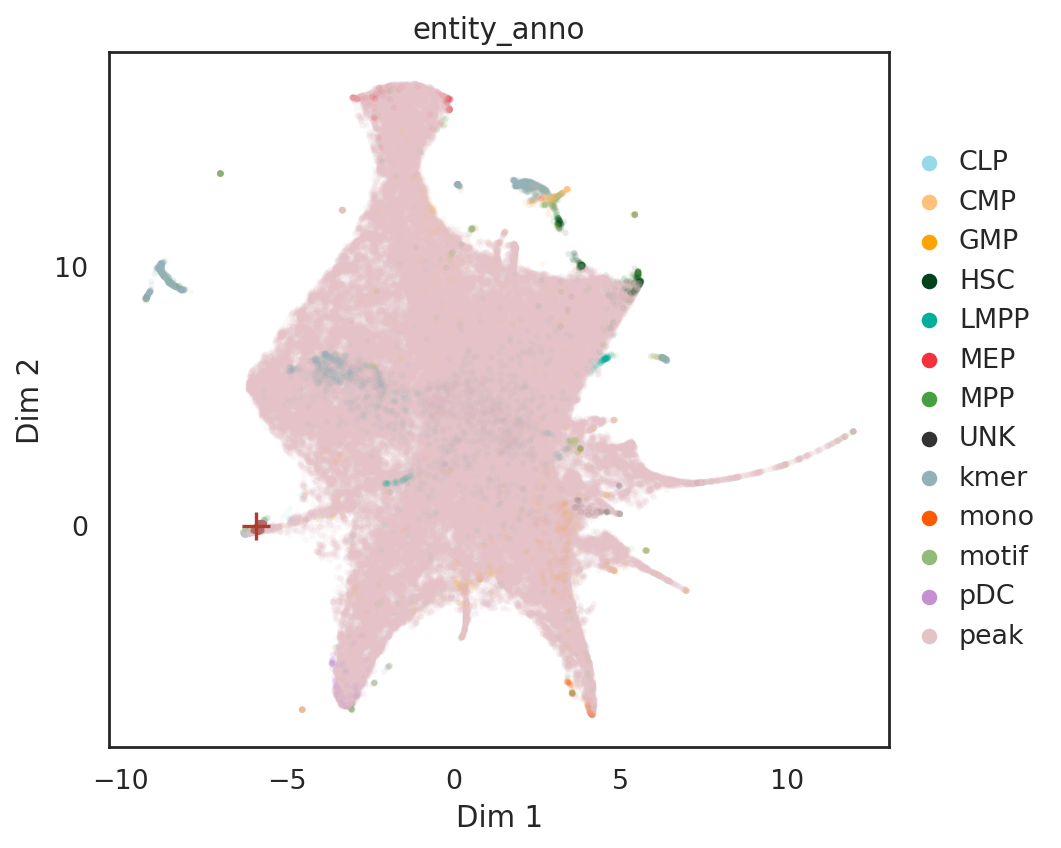

In [67]:
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            show_texts=False,
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(6.5,5.5))

### save results

In [61]:
adata_CP.write(os.path.join(workdir, 'adata_CP.h5ad'))
adata_PM.write(os.path.join(workdir, 'adata_PM.h5ad'))
adata_PK.write(os.path.join(workdir, 'adata_PK.h5ad'))
adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_P.write(os.path.join(workdir, 'adata_P.h5ad'))
adata_K.write(os.path.join(workdir, 'adata_K.h5ad'))
adata_M.write(os.path.join(workdir, 'adata_M.h5ad'))
adata_all.write(os.path.join(workdir,'adata_all.h5ad'))
adata_cmp_CM.write(os.path.join(workdir,'adata_cmp_CM.h5ad'))
adata_cmp_CK.write(os.path.join(workdir,'adata_cmp_CK.h5ad'))

... storing 'pbg_id' as categorical
... storing 'pbg_id' as categorical
... storing 'pbg_id' as categorical
... storing 'celltype' as categorical
... storing 'id_dataset' as categorical
... storing 'entity_anno' as categorical


Read back anndata objects
```python
adata_CP = si.read_h5ad(os.path.join(workdir, 'adata_CP.h5ad'))
adata_PM = si.read_h5ad(os.path.join(workdir, 'adata_PM.h5ad'))
adata_PK = si.read_h5ad(os.path.join(workdir, 'adata_PK.h5ad'))
adata_C = si.read_h5ad(os.path.join(workdir, 'adata_C.h5ad'))
adata_P = si.read_h5ad(os.path.join(workdir, 'adata_P.h5ad'))
adata_K = si.read_h5ad(os.path.join(workdir, 'adata_K.h5ad'))
adata_M = si.read_h5ad(os.path.join(workdir, 'adata_M.h5ad'))
adata_all = si.read_h5ad(os.path.join(workdir,'adata_all.h5ad'))
adata_cmp_CM = si.read_h5ad(os.path.join(workdir,'adata_cmp_CM.h5ad'))
adata_cmp_CK = si.read_h5ad(os.path.join(workdir,'adata_cmp_CK.h5ad'))
```